In [1]:
import numpy as np
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt   
import seaborn as sns
import psycopg2
import pickle
from sklearn.svm import SVR

In [2]:
connection = psycopg2.connect(database="edw_dev", user="postgres", password="AocAvalonPG123", host="52.15.157.95",port=5432)
cursor = connection.cursor()

In [3]:
data = pd.read_sql_query('select edw_fact.mme_details."procedure date",edw_src.patient_info.gender, edw_src.patient_info.length_of_stay,edw_fact.mme_details.master_procedure,edw_fact.mme_details.patient_type,edw_fact.mme_details.physician_name,edw_fact.mme_details.age,edw_fact.mme_details.bmi,edw_fact.mme_details.mme_medication_administrated_perdayavg from edw_fact.mme_details full outer join edw_src.patient_info on edw_fact.mme_details.unique_opd_id = edw_src.patient_info.procedure_id;',con=connection)
data = data.replace('INPATIENT','IN-PATIENT')
data.head()

,procedure date,gender,length_of_stay,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg
0,2018-02-08,M,0,ARTHROSCOPY,OUT PATIENT,"WOLF, BRIAN R",41,36.44,12.00
1,2018-04-10,F,2,ARTHROSCOPY SHOULDER,IN-PATIENT,"PATTERSON, BRENDAN M",69,37.51,45.00
2,2018-07-31,M,0,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",63,38.02,30.34
3,2019-12-31,M,1,ARTHROPLASTY,OUT PATIENT,"NOISEUX, NICOLAS O",65,31.68,53.83
4,2019-12-03,M,0,ARTHROSCOPY SHOULDER,OUT PATIENT,"BOLLIER, MATTHEW J",61,24.91,30.00


In [4]:
data.isna().sum()

procedure date                               0
gender                                       0
length_of_stay                               0
master_procedure                             0
patient_type                                 1
physician_name                               0
age                                          0
bmi                                        106
mme_medication_administrated_perdayavg    1146
dtype: int64

In [5]:
data =  data.dropna()
data = data.drop_duplicates()
data.shape

(11472, 9)

In [6]:
data['gender'].unique()

array(['M', 'F'], dtype=object)

In [7]:
len(list(data['master_procedure'].unique()))

64

In [8]:
list(data['master_procedure'].unique())

['ARTHROSCOPY',
 'ARTHROSCOPY SHOULDER',
 'ARTHROPLASTY',
 'CONVERSION ARTHROPLASTY',
 ' ARTHROPLASTY, HIP',
 'ARTHROSCOPY HIP ',
 'ARTHROSCOPY KNEE',
 'HARDWARE REMOVAL',
 'ARTHROPLASTY, KNEE',
 'ANT CRUC LIGAMENT',
 'INTRAMEDULLARY NAIL FEMUR CEPHALOMEDULLARY NAIL',
 'POSTERIOR CRUCIATE LIGAMENT (PCL) RECONSTRUCTION/ LIGAMENT',
 'PERONEAL NERVE EXPLORATION/LYSIS',
 'OATS/MOSAICPLASTY KNEE ',
 'AMPUTATION LEG BELOW',
 'ARTHROTOMY',
 'FULKERSON',
 'CARTILAGE RESURFACING',
 'OSTEOTOMY TIBIA',
 'VS',
 'PERIACETABULAR',
 'IRRIGATION/DEBRIDEMENT HIP',
 'EXTENSOR MECHANISM',
 'ARTHROPLASTY KNEE',
 'FASCIOTOMY LOWER',
 'NERVE EXPLORATION ',
 'IRRIGATION/DEBRIDEMENT',
 'SHOULDER STABILIZATION AND ORIF',
 'TENDON REPAIR BICEPS ',
 'AMPUTATION LEG ABOVE',
 'REVERSE',
 'ARTHROPLASTY SHOULDER',
 'OPEN REDUCTION HIP FRACTURE',
 'EXCISION MASS',
 'OSTEOTOMY FEMUR',
 'REVISION ARTHROPLASTY KNEE PATELLA/FEMORAL',
 'IRRIGATION/DEBRIDEMENT SHOULDER',
 'PERCUTANEOUS PINNING HIP',
 'OPEN BICEPS TENODESIS

In [9]:
a = list(data[data['bmi'] > 50].index)
len(a)

203

In [10]:
data = data.drop(a)

In [11]:
data.shape

(11269, 9)

In [12]:
data.bmi.max()

50.0

In [13]:
data[data['bmi']>50]

,procedure date,gender,length_of_stay,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg


In [14]:
b = list(data[data['mme_medication_administrated_perdayavg'] > 200].index)
len(b)

69

In [15]:
data = data.drop(b)
data.shape

(11200, 9)

In [16]:
data = data.replace('INPATIENT','IN-PATIENT')

In [17]:
df = data.copy()

In [19]:
data['Patient_category']= ['Old' if x>=45 else 'Adult' if 21<=x<45 else 'Young' for x in data['age']]
data['BMI_category']= ['Under weight' if x<=18.5 else 'Normal' if 18.5<x<=24.5 else 'Over weight' for x in data['bmi']]

In [20]:
data.head()

,procedure date,gender,length_of_stay,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg,Patient_category,BMI_category
0,2018-02-08,M,0,ARTHROSCOPY,OUT PATIENT,"WOLF, BRIAN R",41,36.44,12.00,Adult,Over weight
1,2018-04-10,F,2,ARTHROSCOPY SHOULDER,IN-PATIENT,"PATTERSON, BRENDAN M",69,37.51,45.00,Old,Over weight
2,2018-07-31,M,0,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",63,38.02,30.34,Old,Over weight
3,2019-12-31,M,1,ARTHROPLASTY,OUT PATIENT,"NOISEUX, NICOLAS O",65,31.68,53.83,Old,Over weight
4,2019-12-03,M,0,ARTHROSCOPY SHOULDER,OUT PATIENT,"BOLLIER, MATTHEW J",61,24.91,30.00,Old,Over weight


In [21]:
features=['master_procedure','patient_type','Patient_category','BMI_category','gender']
Output=['mme_medication_administrated_perdayavg']
categorical_features=['master_procedure','patient_type','Patient_category','BMI_category','gender']


doctor_name='PATTERSON, BRENDAN M'

filtered_data_dict={}
input_outup_col_list=features+Output

In [22]:
list_of_unique_doctor=list(data['physician_name'].unique())
copy_data=copy.deepcopy(data)


for item in list_of_unique_doctor:
    

    filtered_data=copy_data[copy_data['physician_name']==item][input_outup_col_list]
    
    grouped_filterd_data=filtered_data.groupby(by=features).mean().reset_index()
    
    encoded_data=pd.get_dummies(filtered_data, columns=categorical_features)
    encoded_data.index=range(len(encoded_data))
    encoded_data=encoded_data.dropna(how='any')
    
    filtered_data_dict[item]=encoded_data
    
#drop_first=True

In [23]:
docter = list(filtered_data_dict.keys())

In [24]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


In [25]:
pkl_filename = "Docter.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(filtered_data_dict, file)

# BOLLIER, MATTHEW J

In [26]:
new = filtered_data_dict['BOLLIER, MATTHEW J']
new.shape

(1848, 36)

In [27]:
new.shape

(1848, 36)

In [28]:
X = new.drop('mme_medication_administrated_perdayavg', axis=1)
y = new['mme_medication_administrated_perdayavg']
X.head()

,"master_procedure_ ARTHROPLASTY, HIP",master_procedure_ANT CRUC LIGAMENT,"master_procedure_ARTHROPLASTY, KNEE",master_procedure_ARTHROSCOPY,master_procedure_ARTHROSCOPY KNEE,master_procedure_ARTHROSCOPY SHOULDER,master_procedure_ARTHROTOMY,master_procedure_CARTILAGE RESURFACING,master_procedure_EXTERNAL FIXATION,master_procedure_FASCIOTOMY LOWER,...,patient_type_IN-PATIENT,patient_type_OUT PATIENT,Patient_category_Adult,Patient_category_Old,Patient_category_Young,BMI_category_Normal,BMI_category_Over weight,BMI_category_Under weight,gender_F,gender_M
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0


C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

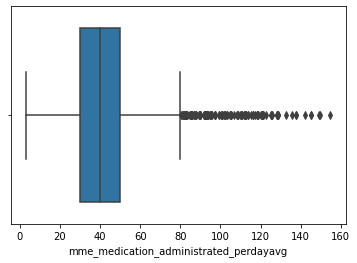

In [29]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

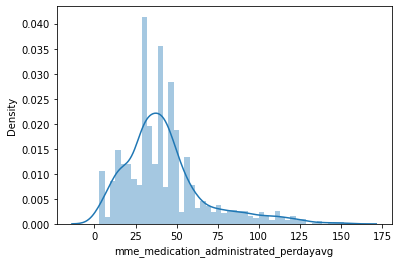

In [30]:
sns.distplot(y)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  1478
Testing data size  370


# SVM Regression

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [34]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [35]:
clf1 = NuSVR(C=100 ,gamma=0.1, kernel='rbf',)
clf1.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [36]:
from sklearn.metrics import r2_score
y_pred = clf1.predict(X_train)
a1 = r2_score(y_train, y_pred)
a1

0.34348478397868687

In [37]:
y_pred = clf1.predict(X_test)

In [38]:
from sklearn.metrics import r2_score
b1 = r2_score(y_test, y_pred)
b1

0.1497751629403924

In [39]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a1, b1,])
print(x)

+----------------+---------------------+--------------------+
|   Model name   |    R-square value   |      Q-Score       |
+----------------+---------------------+--------------------+
| SVM Regression | 0.34348478397868687 | 0.1497751629403924 |
+----------------+---------------------+--------------------+


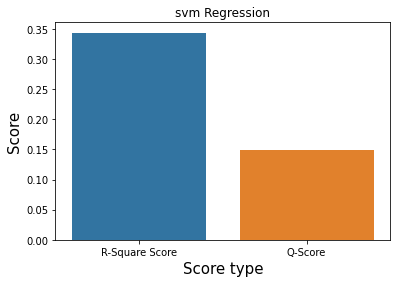

In [40]:
l = [ (r2_score(y_train, clf1.predict(X_train))),(r2_score(y_test, clf1.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [41]:
pkl_filename = "BOLLIER, MATTHEW J.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf1, file)

# 2nd Highest Docter

In [42]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


In [43]:
new1 = filtered_data_dict['NOISEUX, NICOLAS O']
new1.shape

(1454, 32)

In [44]:
X = new1.drop('mme_medication_administrated_perdayavg', axis=1)
y = new1['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

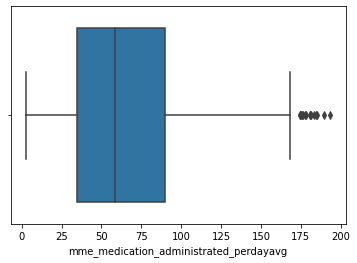

In [45]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

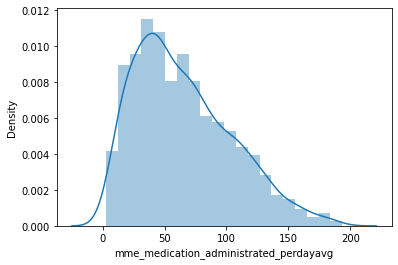

In [46]:
sns.distplot(y)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  1163
Testing data size  291


# SVM Regression

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [50]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [51]:
clf2 = NuSVR(C=100, gamma=0.01, kernel='rbf')
clf2.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [52]:
y_pred = clf2.predict(X_train)
a2 = r2_score(y_train, y_pred)
a2

0.09301699225712656

In [53]:
y_pred = clf2.predict(X_test)

In [54]:
from sklearn.metrics import r2_score
b2 = r2_score(y_test, y_pred)
b2

0.06452895745421638

In [55]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["svm Regression",a2, b2,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| svm Regression | 0.09301699225712656 | 0.06452895745421638 |
+----------------+---------------------+---------------------+


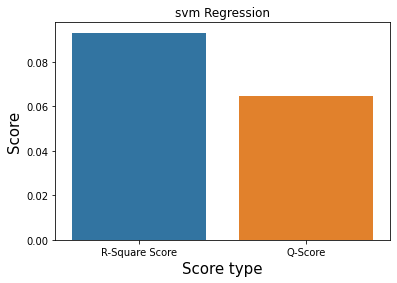

In [56]:
l = [ (r2_score(y_train, clf2.predict(X_train))),(r2_score(y_test, clf2.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [57]:
pkl_filename = "NOISEUX, NICOLAS O.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf2, file)

In [58]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# WESTERMANN, ROBERT

In [59]:
new6 = filtered_data_dict['WESTERMANN, ROBERT']
new6.shape

(1314, 42)

In [60]:
X = new6.drop('mme_medication_administrated_perdayavg', axis=1)
y = new6['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

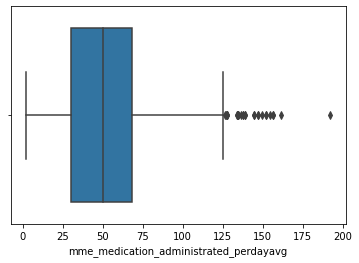

In [61]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

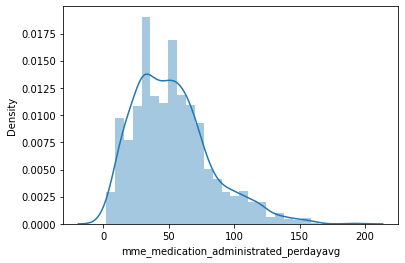

In [62]:
sns.distplot(y)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  1051
Testing data size  263


# SVM Regression

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [66]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [67]:
clf3 = NuSVR(C=10 , gamma=0.1, kernel='rbf')
clf3.fit(X_train,y_train)

NuSVR(C=10, gamma=0.1)

In [68]:
y_pred = clf3.predict(X_train)
a3 = r2_score(y_train, y_pred) 
a3

0.12246716002776803

In [69]:
y_pred = clf3.predict(X_test)

In [70]:
b3 = r2_score(y_test, y_pred)
b3

0.11787827906958404

In [71]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a3, b3,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.12246716002776803 | 0.11787827906958404 |
+----------------+---------------------+---------------------+


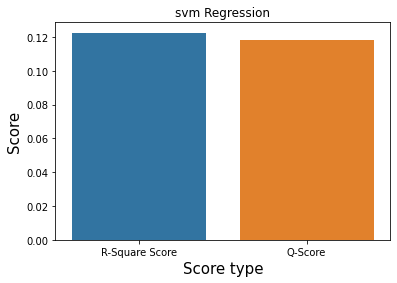

In [72]:
l = [ (r2_score(y_train, clf3.predict(X_train))),(r2_score(y_test, clf3.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [73]:
pkl_filename = "WESTERMANN, ROBERT.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf3, file)

# BROWN, TIMOTHY S

In [74]:
new2 = filtered_data_dict['BROWN, TIMOTHY S']
new2.shape

(1029, 35)

In [75]:
X = new2.drop('mme_medication_administrated_perdayavg', axis=1)
y = new2['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

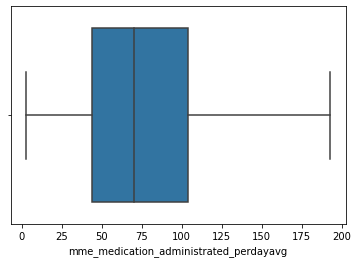

In [76]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

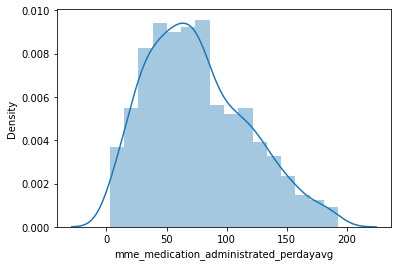

In [77]:
sns.distplot(y)

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  823
Testing data size  206


# SVM Regression

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [81]:
print(grid.best_estimator_)

NuSVR(C=10, gamma=0.1)


In [82]:
clf4 = NuSVR(C=10, gamma=0.1, kernel='rbf')
clf4.fit(X_train,y_train)

NuSVR(C=10, gamma=0.1)

In [83]:
y_pred = clf4.predict(X_train)
a4 = r2_score(y_train, y_pred)
a4

0.07576235133024534

In [84]:
y_pred = clf4.predict(X_test)

In [85]:
from sklearn.metrics import r2_score
b4 = r2_score(y_test, y_pred)
b4

0.05213291219217009

In [86]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a4, b4,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.07576235133024534 | 0.05213291219217009 |
+----------------+---------------------+---------------------+


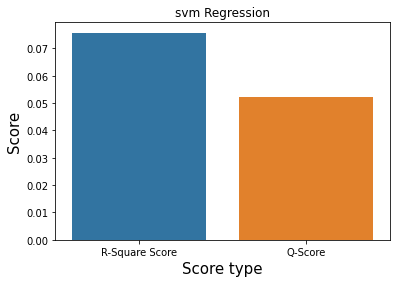

In [87]:
l = [ (r2_score(y_train, clf4.predict(X_train))),(r2_score(y_test, clf4.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [88]:
pkl_filename = "BROWN, TIMOTHY S.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf4, file)

In [89]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# WOLF, BRIAN R

In [90]:
new3 = filtered_data_dict['WOLF, BRIAN R']
new3.shape

(840, 35)

In [91]:
X = new3.drop('mme_medication_administrated_perdayavg', axis=1)
y = new3['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

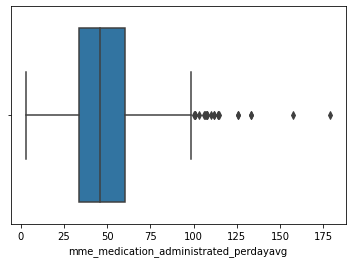

In [92]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

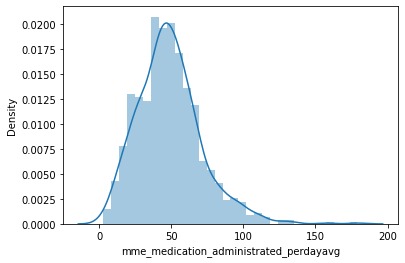

In [93]:
sns.distplot(y)

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  672
Testing data size  168


# SVM Regression

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [97]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [98]:
clf5 = NuSVR(C=100,  gamma=0.1, kernel='rbf')
clf5.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [99]:
y_pred = clf5.predict(X_train)
a5 = r2_score(y_train, y_pred)
a5

0.2922350975821174

In [100]:
y_pred = clf5.predict(X_test)

In [101]:
from sklearn.metrics import r2_score
b5 = r2_score(y_test, y_pred)
b5

0.11642237914282838

In [102]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a5, b5,])
print(x)

+----------------+--------------------+---------------------+
|   Model name   |   R-square value   |       Q-Score       |
+----------------+--------------------+---------------------+
| SVM Regression | 0.2922350975821174 | 0.11642237914282838 |
+----------------+--------------------+---------------------+


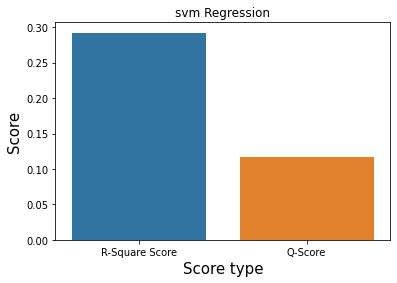

In [103]:
l = [ (r2_score(y_train, clf5.predict(X_train))),(r2_score(y_test, clf5.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [104]:
pkl_filename = "WOLF, BRIAN R.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf5, file)

In [105]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# NEPOLA, JAMES V

In [106]:
new4 = filtered_data_dict['NEPOLA, JAMES V']
new4.shape

(633, 29)

In [107]:
X = new4.drop('mme_medication_administrated_perdayavg', axis=1)
y = new4['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

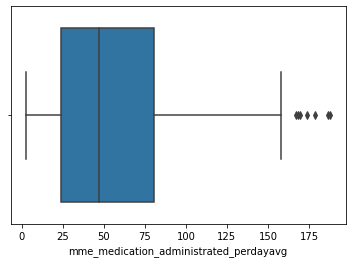

In [108]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

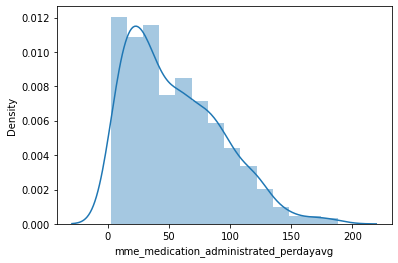

In [109]:
sns.distplot(y)

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  506
Testing data size  127


# SVM Regression

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [113]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [114]:
clf6 = NuSVR(C=100, gamma=0.01, kernel='rbf')
clf6.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [115]:
y_pred = clf6.predict(X_train)
a6 = r2_score(y_train, y_pred)
a6

0.12422575810940961

In [116]:
y_pred = clf6.predict(X_test)

In [117]:
from sklearn.metrics import r2_score
b6 = r2_score(y_test, y_pred)
b6

0.14789359421538684

In [118]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a6, b6,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.12422575810940961 | 0.14789359421538684 |
+----------------+---------------------+---------------------+


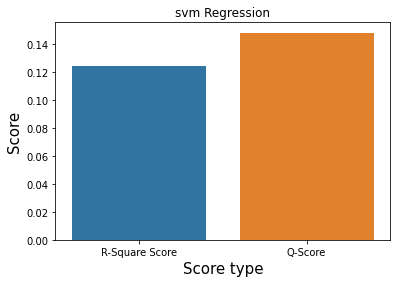

In [119]:
l = [ (r2_score(y_train, clf6.predict(X_train))),(r2_score(y_test, clf6.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [120]:
pkl_filename = "NEPOLA, JAMES V.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf6, file)

In [121]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# OTERO, JESSE E

In [122]:
new5 = filtered_data_dict['OTERO, JESSE E']
new5.shape

(593, 29)

In [123]:
X = new5.drop('mme_medication_administrated_perdayavg', axis=1)
y = new5['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

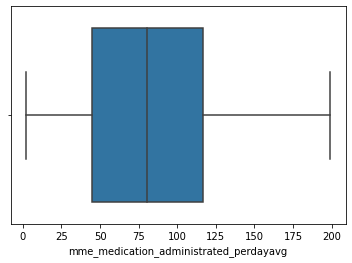

In [124]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

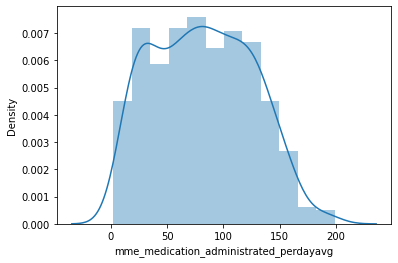

In [125]:
sns.distplot(y)

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  474
Testing data size  119


# SVM Regression

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [129]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [130]:
clf7 = NuSVR(C=100,  gamma=0.1, kernel='rbf')
clf7.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [131]:
y_pred = clf7.predict(X_train)
a7 = r2_score(y_train, y_pred)
a7

0.16724497112616288

In [132]:
y_pred = clf7.predict(X_test)

In [133]:
b7 = r2_score(y_test, y_pred)
b7

0.05216857165695277

In [134]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a7, b7,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.16724497112616288 | 0.05216857165695277 |
+----------------+---------------------+---------------------+


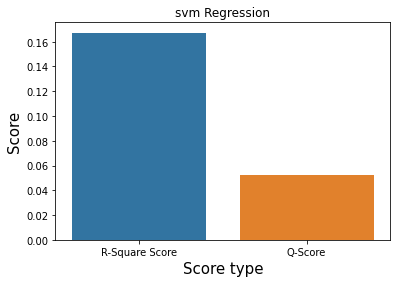

In [135]:
l = [ (r2_score(y_train, clf7.predict(X_train))),(r2_score(y_test, clf7.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [136]:
pkl_filename = "OTERO, JESSE E.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf7, file)

In [137]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# WILLEY, MICHAEL C

In [138]:
new7 = filtered_data_dict['WILLEY, MICHAEL C']
new7.shape

(527, 39)

In [139]:
X = new7.drop('mme_medication_administrated_perdayavg', axis=1)
y = new7['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

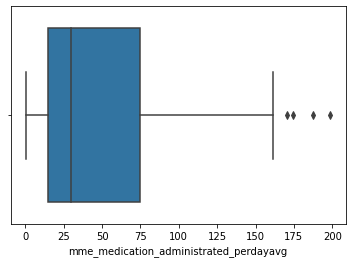

In [140]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

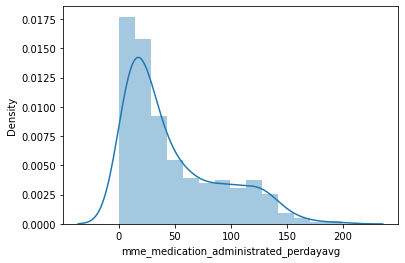

In [141]:
sns.distplot(y)

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  421
Testing data size  106


# SVM Regression

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [145]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [146]:
clf8 = NuSVR(C=100, gamma=0.01, kernel='rbf')
clf8.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [147]:
y_pred = clf8.predict(X_train)
a8 = r2_score(y_train, y_pred)
a8

0.17250741014360493

In [148]:
y_pred = clf8.predict(X_test)

In [149]:
b8 = r2_score(y_test, y_pred)
b8

0.034088349345401614

In [150]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a8, b8,])
print(x)

+----------------+---------------------+----------------------+
|   Model name   |    R-square value   |       Q-Score        |
+----------------+---------------------+----------------------+
| SVM Regression | 0.17250741014360493 | 0.034088349345401614 |
+----------------+---------------------+----------------------+


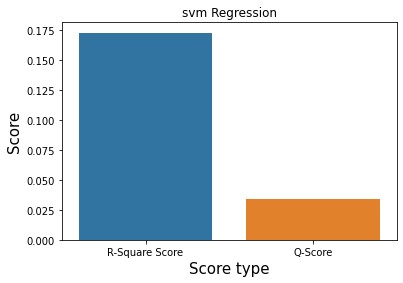

In [151]:
l = [ (r2_score(y_train, clf8.predict(X_train))),(r2_score(y_test, clf8.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [152]:
pkl_filename = "WILLEY, MICHAEL C.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf8, file)

# DUCHMAN, KYLE R

In [153]:
new8 = filtered_data_dict['DUCHMAN, KYLE R']
new8.shape

(484, 39)

In [154]:
X = new8.drop('mme_medication_administrated_perdayavg', axis=1)
y = new8['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

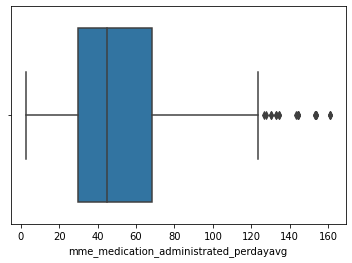

In [155]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

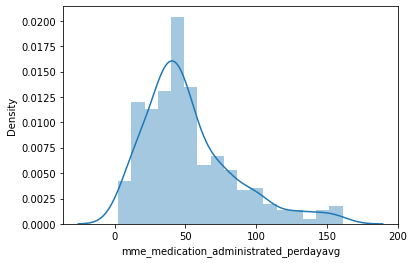

In [156]:
sns.distplot(y)

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  387
Testing data size  97


# SVM Regression

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [160]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [161]:
clf9 = NuSVR(C=100, gamma=0.1, kernel='rbf')
clf9.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [162]:
y_pred = clf9.predict(X_train)
a9 = r2_score(y_train, y_pred)
a9

0.5288008891710265

In [163]:
y_pred = clf9.predict(X_test)

In [164]:
b9=r2_score(y_test, y_pred)
b9

0.28509555208152104

In [165]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a9, b9,])
print(x)

+----------------+--------------------+---------------------+
|   Model name   |   R-square value   |       Q-Score       |
+----------------+--------------------+---------------------+
| SVM Regression | 0.5288008891710265 | 0.28509555208152104 |
+----------------+--------------------+---------------------+


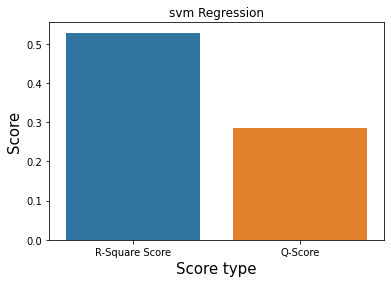

In [166]:
l = [ (r2_score(y_train, clf9.predict(X_train))),(r2_score(y_test, clf9.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [167]:
pkl_filename = "DUCHMAN, KYLE R.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf9, file)

In [168]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# PATTERSON, BRENDAN M

In [169]:
new9 = filtered_data_dict['PATTERSON, BRENDAN M']
new9.shape

(426, 31)

In [170]:
X = new9.drop('mme_medication_administrated_perdayavg', axis=1)
y = new9['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

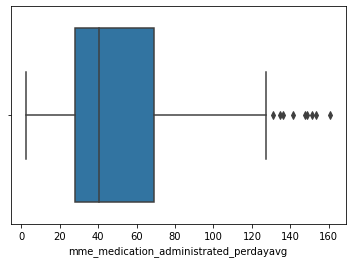

In [171]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

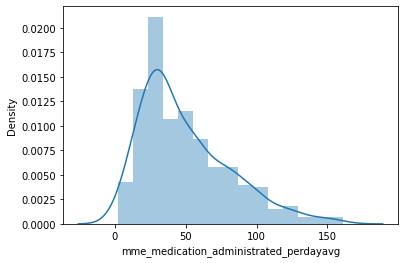

In [172]:
sns.distplot(y)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  340
Testing data size  86


# SVm Regression

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [176]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [177]:
clf10 = NuSVR(C=100, gamma=0.01, kernel='rbf')
clf10.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [178]:
y_pred = clf10.predict(X_train)
a10 = r2_score(y_train, y_pred)
a10

0.18395525839222626

In [179]:
y_pred = clf10.predict(X_test)
b10 = r2_score(y_test, y_pred)
b10

0.11327797584803534

In [180]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a10, b10,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.18395525839222626 | 0.11327797584803534 |
+----------------+---------------------+---------------------+


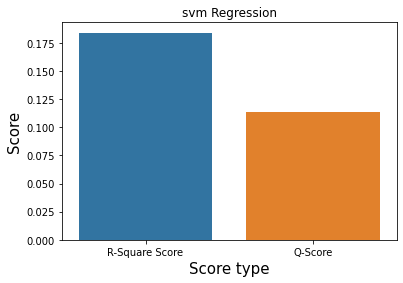

In [181]:
l = [ (r2_score(y_train, clf10.predict(X_train))),(r2_score(y_test, clf10.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [182]:
pkl_filename = "PATTERSON, BRENDAN M.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf10, file)

In [183]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# KARAM, MATTHEW D

In [184]:
new10 = filtered_data_dict['KARAM, MATTHEW D']
new10.shape

(355, 34)

In [185]:
X = new10.drop('mme_medication_administrated_perdayavg', axis=1)
y = new10['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

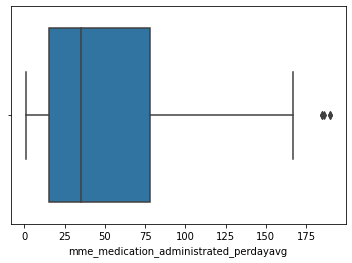

In [186]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

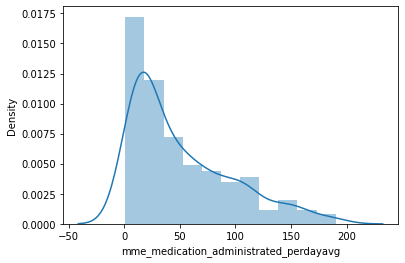

In [187]:
sns.distplot(y)

In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  284
Testing data size  71


# SVM Regression

In [190]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [191]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [192]:
clf11 = NuSVR(C=100,  gamma=0.01, kernel='rbf')

clf11.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [193]:
y_pred = clf11.predict(X_train)
a11 = r2_score(y_train, y_pred)
a11

0.15793695443489786

In [194]:
y_pred = clf11.predict(X_test)
b11 =r2_score(y_test, y_pred)
b11

0.01240277255574107

In [195]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a11, b11,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.15793695443489786 | 0.01240277255574107 |
+----------------+---------------------+---------------------+


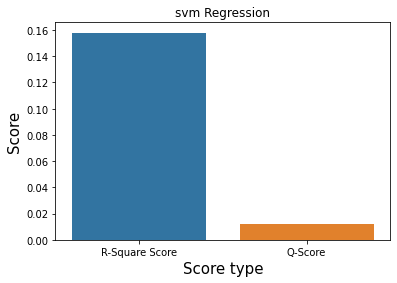

In [196]:
l = [ (r2_score(y_train, clf11.predict(X_train))),(r2_score(y_test, clf11.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [197]:
pkl_filename = "KARAM, MATTHEW D.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf11, file)

In [198]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# BEDARD, NICHOLAS A

In [199]:
new11 = filtered_data_dict['BEDARD, NICHOLAS A']
new11.shape

(347, 22)

In [200]:
X = new11.drop('mme_medication_administrated_perdayavg', axis=1)
y = new11['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

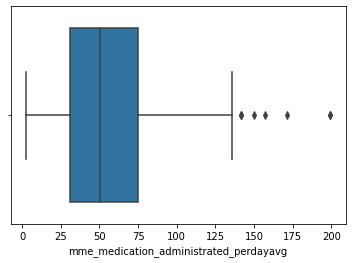

In [201]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

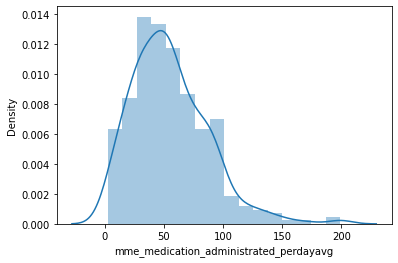

In [202]:
sns.distplot(y)

In [203]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  277
Testing data size  70


# SVM Regression

In [205]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [206]:
print(grid.best_estimator_)

NuSVR(C=10, gamma=0.1)


In [207]:
clf12 = NuSVR(C=10, gamma=0.1, kernel='rbf')
clf12.fit(X_train,y_train)

NuSVR(C=10, gamma=0.1)

In [208]:
y_pred = clf12.predict(X_train)
a12 = r2_score(y_train, y_pred)
a12

0.05204332394383604

In [209]:
y_pred = clf12.predict(X_test)
b12 = r2_score(y_test, y_pred)
b12

0.040213542772993605

In [210]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a12, b12,])
print(x)

+----------------+---------------------+----------------------+
|   Model name   |    R-square value   |       Q-Score        |
+----------------+---------------------+----------------------+
| SVM Regression | 0.05204332394383604 | 0.040213542772993605 |
+----------------+---------------------+----------------------+


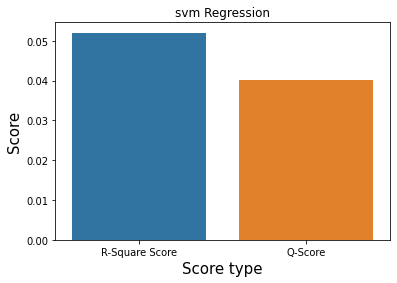

In [211]:
l = [ (r2_score(y_train, clf12.predict(X_train))),(r2_score(y_test, clf12.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [212]:
pkl_filename = "BEDARD, NICHOLAS A.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf12, file)

In [213]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# MILLER, BENJAMIN J

In [214]:
new12 = filtered_data_dict['MILLER, BENJAMIN J']
new12.shape

(285, 43)

In [215]:
X = new12.drop('mme_medication_administrated_perdayavg', axis=1)
y = new12['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

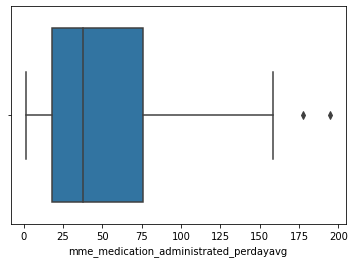

In [216]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

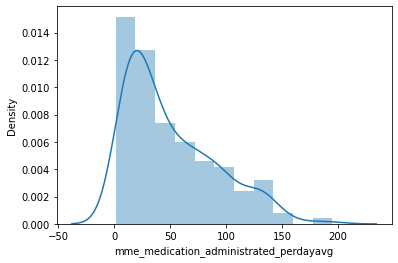

In [217]:
sns.distplot(y)

In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# SVM Regression

In [219]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [220]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [221]:
clf13 = NuSVR(C=100, gamma=0.1, kernel='rbf')
clf13.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [222]:
y_pred = clf13.predict(X_train)
a13 = r2_score(y_train, y_pred)
a13

0.4071750315414332

In [223]:
y_pred = clf13.predict(X_test)
b13 = r2_score(y_test, y_pred)
b13

0.09418527813085131

In [224]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a13, b13,])
print(x)

+----------------+--------------------+---------------------+
|   Model name   |   R-square value   |       Q-Score       |
+----------------+--------------------+---------------------+
| SVM Regression | 0.4071750315414332 | 0.09418527813085131 |
+----------------+--------------------+---------------------+


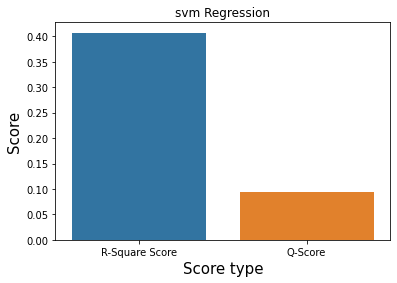

In [225]:
l = [ (r2_score(y_train, clf13.predict(X_train))),(r2_score(y_test, clf13.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [226]:
pkl_filename = "MILLER, BENJAMIN J.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf13, file)

In [227]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# ELKINS, JACOB M

In [228]:
new13 = filtered_data_dict['ELKINS, JACOB M']
new13.shape

(247, 30)

In [229]:
X = new13.drop('mme_medication_administrated_perdayavg', axis=1)
y = new13['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

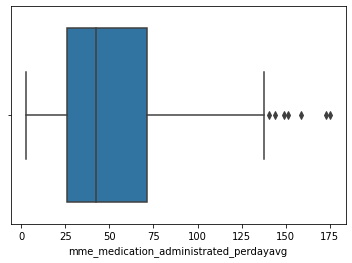

In [230]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

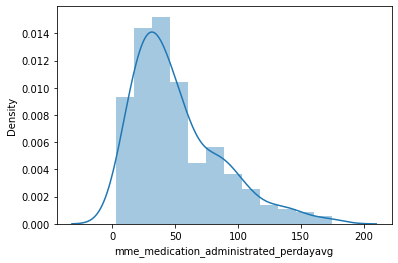

In [231]:
sns.distplot(y)

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  197
Testing data size  50


# SVM Regression

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [235]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.01)


In [236]:
clf14 = NuSVR(C=100, gamma=0.01, kernel='rbf')
clf14.fit(X_train,y_train)

NuSVR(C=100, gamma=0.01)

In [237]:
y_pred = clf14.predict(X_train)
a14 = r2_score(y_train, y_pred)
a14

0.038246918512072736

In [238]:
y_pred = clf14.predict(X_test)
b14= r2_score(y_test, y_pred)
b14

0.03186503241616945

In [239]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a14, b14,])
print(x)

+----------------+----------------------+---------------------+
|   Model name   |    R-square value    |       Q-Score       |
+----------------+----------------------+---------------------+
| SVM Regression | 0.038246918512072736 | 0.03186503241616945 |
+----------------+----------------------+---------------------+


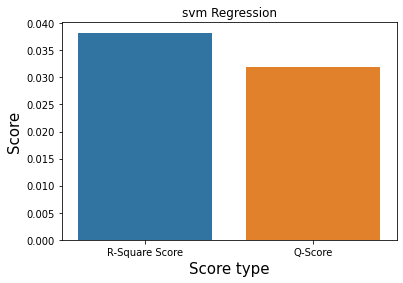

In [240]:
l = [ (r2_score(y_train, clf14.predict(X_train))),(r2_score(y_test, clf14.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [241]:
pkl_filename = "ELKINS, JACOB M.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf14, file)

In [242]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# HOGUE, MATTHEW H

In [243]:
new14 = filtered_data_dict['HOGUE, MATTHEW H']
new14.shape

(230, 30)

In [244]:
X = new14.drop('mme_medication_administrated_perdayavg', axis=1)
y = new14['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

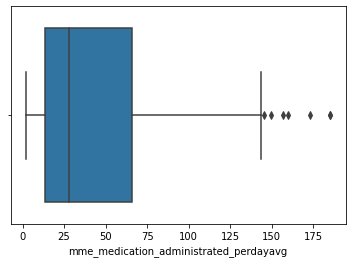

In [245]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

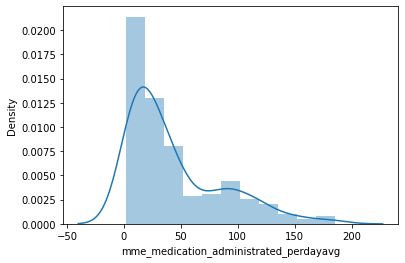

In [246]:
sns.distplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

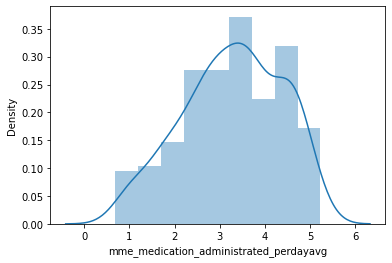

In [247]:
sns.distplot(np.log(y))

In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [249]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  184
Testing data size  46


# SVM Regression

In [250]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [251]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [252]:
clf15 = NuSVR(C=100, gamma=0.1, kernel='rbf')
clf15.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [253]:
y_pred = clf15.predict(X_train)
a15 = r2_score(y_train, y_pred)
a15

0.3196258243347355

In [254]:
y_pred = clf15.predict(X_test)
b15= r2_score(y_test, y_pred)
b15

0.030113924789138213

In [255]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a15, b15,])
print(x)

+----------------+--------------------+----------------------+
|   Model name   |   R-square value   |       Q-Score        |
+----------------+--------------------+----------------------+
| SVM Regression | 0.3196258243347355 | 0.030113924789138213 |
+----------------+--------------------+----------------------+


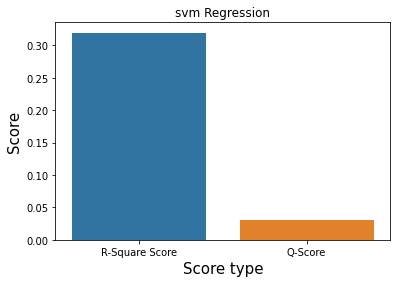

In [256]:
l = [ (r2_score(y_train, clf15.predict(X_train))),(r2_score(y_test, clf15.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [257]:
pkl_filename = "HOGUE, MATTHEW H.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf15, file)

In [258]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# HOLT, JOSHUA

In [259]:
new15 = filtered_data_dict['HOLT, JOSHUA']
new15.shape

(97, 30)

In [260]:
X = new15.drop('mme_medication_administrated_perdayavg', axis=1)
y = new15['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

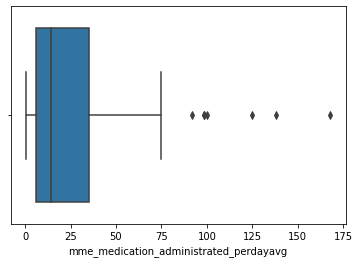

In [261]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

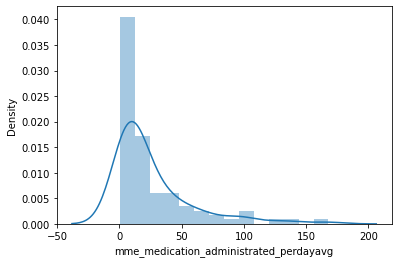

In [262]:
sns.distplot(y)

In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [264]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  77
Testing data size  20


# SVM Regression

In [265]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [266]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=0.1)


In [267]:
clf16 = NuSVR(C=100, gamma=0.1, kernel='rbf')
clf16.fit(X_train,y_train)

NuSVR(C=100, gamma=0.1)

In [268]:
y_pred = clf16.predict(X_train)
a16 = r2_score(y_train, y_pred)
a16

0.5416769107786618

In [269]:
y_pred = clf16.predict(X_test)
b16 =r2_score(y_test, y_pred)
b16

0.42167502244116606

In [270]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a16, b16,])
print(x)

+----------------+--------------------+---------------------+
|   Model name   |   R-square value   |       Q-Score       |
+----------------+--------------------+---------------------+
| SVM Regression | 0.5416769107786618 | 0.42167502244116606 |
+----------------+--------------------+---------------------+


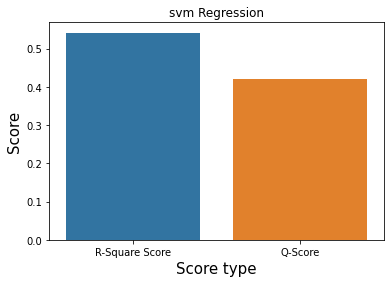

In [271]:
l = [ (r2_score(y_train, clf16.predict(X_train))),(r2_score(y_test, clf16.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [272]:
pkl_filename = "HOLT, JOSHUA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf16, file)

In [273]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# MARSH, JOHN L

In [274]:
new16 = filtered_data_dict['MARSH, JOHN L']
new16.shape

(103, 25)

In [275]:
X = new16.drop('mme_medication_administrated_perdayavg', axis=1)
y = new16['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

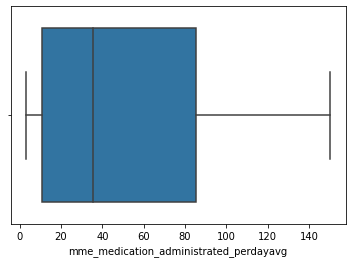

In [276]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

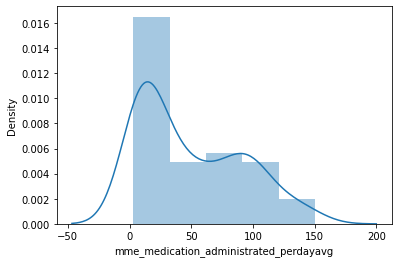

In [277]:
sns.distplot(y)

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [279]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  82
Testing data size  21


# SVM Regression

In [280]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=2)
grid.fit(X_train,y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [281]:
print(grid.best_estimator_)

NuSVR(C=0.1, gamma=0.001)


In [282]:
clf17 = NuSVR(C=0.1,  gamma=0.001, kernel='rbf')
clf17.fit(X_train,y_train)

NuSVR(C=0.1, gamma=0.001)

In [283]:
y_pred = clf17.predict(X_train)
a17 = r2_score(y_train, y_pred)
a17

-0.0006785078365827424

In [284]:
y_pred = clf17.predict(X_test)
b17 = r2_score(y_test, y_pred)
b17

-0.15554244323799438

In [285]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a17, b17,])
print(x)

+----------------+------------------------+----------------------+
|   Model name   |     R-square value     |       Q-Score        |
+----------------+------------------------+----------------------+
| SVM Regression | -0.0006785078365827424 | -0.15554244323799438 |
+----------------+------------------------+----------------------+


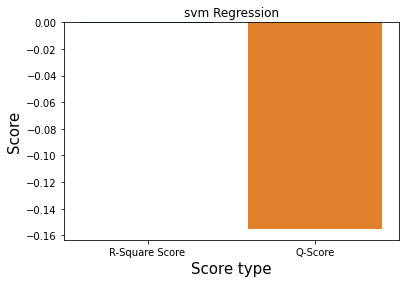

In [286]:
l = [ (r2_score(y_train, clf17.predict(X_train))),(r2_score(y_test, clf17.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [287]:
pkl_filename = "MARSH, JOHN L.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf17, file)

In [288]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# BUCKWALTER V, JOSEPH A (HAND)

In [289]:
new17 = filtered_data_dict['BUCKWALTER V, JOSEPH A (HAND)']
new17.shape

(72, 27)

In [290]:
X = new17.drop('mme_medication_administrated_perdayavg', axis=1)
y = new17['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

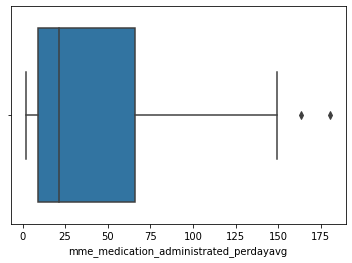

In [291]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

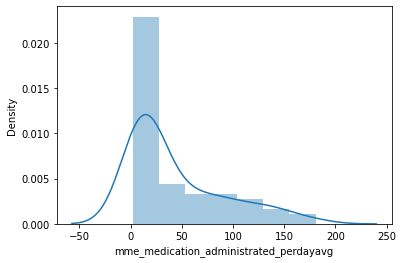

In [292]:
sns.distplot(y)

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [294]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  57
Testing data size  15


# SVM Regression

In [295]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [296]:
print(grid.best_estimator_)

NuSVR(C=10, gamma=0.01)


In [297]:
clf18 = NuSVR(C=10, gamma=1, kernel='rbf')
clf18.fit(X_train,y_train)

NuSVR(C=10, gamma=1)

In [298]:
y_pred = clf18.predict(X_train)
a18 = r2_score(y_train, y_pred)
a18

0.23211473500304114

In [299]:
y_pred = clf18.predict(X_test)
b18= r2_score(y_test, y_pred)
b18

-1.4208827091325733

In [300]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a18, b18,])
print(x)

+----------------+---------------------+---------------------+
|   Model name   |    R-square value   |       Q-Score       |
+----------------+---------------------+---------------------+
| SVM Regression | 0.23211473500304114 | -1.4208827091325733 |
+----------------+---------------------+---------------------+


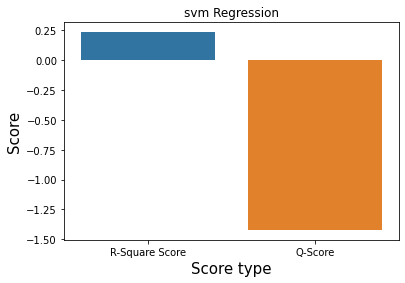

In [301]:
l = [ (r2_score(y_train, clf18.predict(X_train))),(r2_score(y_test, clf18.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [302]:
pkl_filename = "BUCKWALTER V, JOSEPH A (HAND).pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf18, file)

In [303]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


# KOWALSKI, HEATHER R

In [304]:
new18 = filtered_data_dict['KOWALSKI, HEATHER R']
new18.shape

(70, 26)

In [305]:
X = new18.drop('mme_medication_administrated_perdayavg', axis=1)
y = new18['mme_medication_administrated_perdayavg']

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg'>

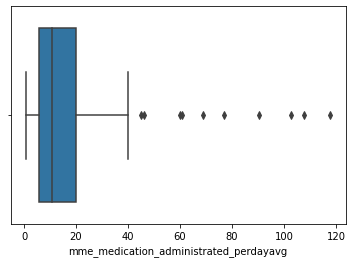

In [306]:
sns.boxplot(y)

C:\Users\harka\anaconda3\envs\new\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mme_medication_administrated_perdayavg', ylabel='Density'>

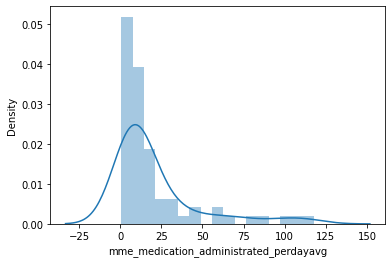

In [307]:
sns.distplot(y)

In [308]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [309]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  56
Testing data size  14


# SVM Regression

In [310]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [311]:
print(grid.best_estimator_)

NuSVR(C=100, gamma=1)


In [312]:
clf19 = NuSVR(C=1, gamma=1, kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)
clf19.fit(X_train,y_train)

NuSVR(C=1, gamma=1)

In [313]:
y_pred = clf19.predict(X_train)
a19 = r2_score(y_train, y_pred)
a19

0.00015882319689675128

In [314]:
y_pred = clf19.predict(X_test)
b19= r2_score(y_test, y_pred)
b19

0.021806700002529267

In [315]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a19, b19,])
print(x)

+----------------+------------------------+----------------------+
|   Model name   |     R-square value     |       Q-Score        |
+----------------+------------------------+----------------------+
| SVM Regression | 0.00015882319689675128 | 0.021806700002529267 |
+----------------+------------------------+----------------------+


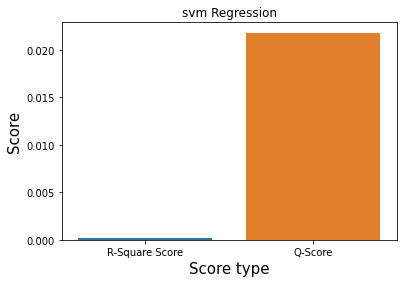

In [316]:
l = [ (r2_score(y_train, clf19.predict(X_train))),(r2_score(y_test, clf19.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [317]:
pkl_filename = "KOWALSKI, HEATHER R.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf19, file)

In [318]:
for i in docter:
    print(filtered_data_dict[i].shape , i)

(840, 35) WOLF, BRIAN R
(426, 31) PATTERSON, BRENDAN M
(1848, 36) BOLLIER, MATTHEW J
(1454, 32) NOISEUX, NICOLAS O
(1029, 35) BROWN, TIMOTHY S
(247, 30) ELKINS, JACOB M
(1314, 42) WESTERMANN, ROBERT
(484, 39) DUCHMAN, KYLE R
(285, 43) MILLER, BENJAMIN J
(633, 29) NEPOLA, JAMES V
(50, 24) MORCUENDE, JOSE A
(527, 39) WILLEY, MICHAEL C
(42, 13) CLARK, CHARLES R
(103, 25) MARSH, JOHN L
(347, 22) BEDARD, NICHOLAS A
(593, 29) OTERO, JESSE E
(37, 18) FOWLER, TIMOTHY P
(355, 34) KARAM, MATTHEW D
(12, 13) LAWLER, ERICKA
(72, 27) BUCKWALTER V, JOSEPH A (HAND)
(52, 25) FEMINO, JOHN E
(97, 30) HOLT, JOSHUA
(70, 26) KOWALSKI, HEATHER R
(17, 13) CALDWELL, LINDSEY S
(5, 10) BUCKWALTER, JOSEPH A
(11, 13) WEINSTEIN, STUART L
(18, 15) DE CESAR NETTO, CESAR
(230, 30) HOGUE, MATTHEW H
(1, 6) CALLAGHAN, JOHN J
(1, 6) PUGELY, ANDREW


In [319]:
new19 = filtered_data_dict['FEMINO, JOHN E']
new19.shape

(52, 25)

In [320]:
X = new19.drop('mme_medication_administrated_perdayavg', axis=1)
y = new19['mme_medication_administrated_perdayavg']

In [321]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
print("Training data size ",X_train.shape[0])
print("Testing data size ",X_test.shape[0])

Training data size  41
Testing data size  11


In [323]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(NuSVR(),param_grid,n_jobs=-1,verbose=2,cv=10)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [324]:
print(grid.best_estimator_)

NuSVR(C=10, gamma=1)


In [325]:
clf20 = NuSVR(C=10,  gamma=1, kernel='rbf')
clf20.fit(X_train,y_train)

NuSVR(C=10, gamma=1)

In [326]:
y_pred = clf20.predict(X_train)
a20 = r2_score(y_train, y_pred)
a20

0.22888818366340813

In [327]:
y_pred = clf20.predict(X_test)
b20= r2_score(y_test, y_pred)
b20

-0.1643449470431988

In [328]:
x = PrettyTable()
x.field_names = ["Model name", "R-square value","Q-Score"]
x.add_row(["SVM Regression",a19, b19,])
print(x)

+----------------+------------------------+----------------------+
|   Model name   |     R-square value     |       Q-Score        |
+----------------+------------------------+----------------------+
| SVM Regression | 0.00015882319689675128 | 0.021806700002529267 |
+----------------+------------------------+----------------------+


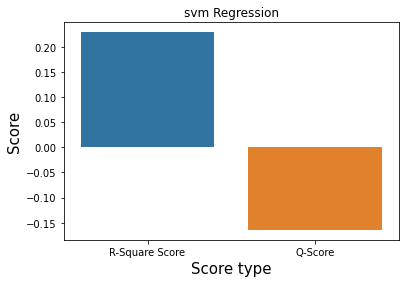

In [329]:
l = [ (r2_score(y_train, clf20.predict(X_train))),(r2_score(y_test, clf20.predict(X_test)))]
c = ["R-Square Score","Q-Score"]
sns.barplot(x=c, y=l)
plt.xlabel('Score type', fontsize =15)
plt.ylabel('Score', fontsize = 15)
plt.title("svm Regression")
plt.show()

In [330]:
pkl_filename = "FEMINO, JOHN E.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf20, file)

In [331]:
R = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19,a20]
len(R)

20

In [332]:
Q = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19,b20]
len(Q)

20

In [333]:
d = ['BOLLIER, MATTHEW J','NOISEUX, NICOLAS O','WESTERMANN, ROBERT','BROWN, TIMOTHY S','WOLF, BRIAN R','NEPOLA, JAMES V','OTERO, JESSE E','WILLEY, MICHAEL C','DUCHMAN, KYLE R','PATTERSON, BRENDAN M','KARAM, MATTHEW D','BEDARD, NICHOLAS A','MILLER, BENJAMIN J','ELKINS, JACOB M','HOGUE, MATTHEW H','HOLT, JOSHUA','MARSH, JOHN L','BUCKWALTER V, JOSEPH A (HAND)','KOWALSKI, HEATHER R','FEMINO, JOHN E']
len(d)

20

In [334]:
df = pd.DataFrame({"R-Square Score":R,"Q Score":Q,'Name':d})
df.head()

,R-Square Score,Q Score,Name
0,0.343485,0.149775,"BOLLIER, MATTHEW J"
1,0.093017,0.064529,"NOISEUX, NICOLAS O"
2,0.122467,0.117878,"WESTERMANN, ROBERT"
3,0.075762,0.052133,"BROWN, TIMOTHY S"
4,0.292235,0.116422,"WOLF, BRIAN R"


In [335]:
df.columns

Index(['R-Square Score', 'Q Score', 'Name'], dtype='object')

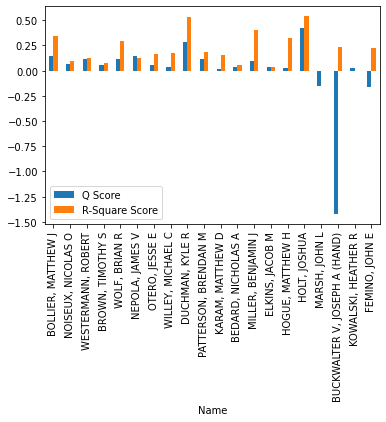

In [336]:
df.plot(x="Name", y=["Q Score","R-Square Score"], kind="bar")
plt.savefig('barplot with.jpg', dpi=1000, bbox_inches='tight')

In [337]:
import joblib
from joblib import dump, load

In [338]:
import joblib

doctor = {'DUCHMAN, KYLE R':joblib.load('DUCHMAN, KYLE R.pkl'),
          'WOLF, BRIAN R':joblib.load('WOLF, BRIAN R.pkl'),
          'BOLLIER, MATTHEW J':joblib.load('BOLLIER, MATTHEW J.pkl'),
          'NOISEUX, NICOLAS O':joblib.load('NOISEUX, NICOLAS O.pkl'),
          'WESTERMANN, ROBERT':joblib.load('WESTERMANN, ROBERT.pkl'),
          'BROWN, TIMOTHY S':joblib.load('BROWN, TIMOTHY S.pkl'),
          'NEPOLA, JAMES V':joblib.load('NEPOLA, JAMES V.pkl'),
          'OTERO, JESSE E':joblib.load('OTERO, JESSE E.pkl'),
          'WILLEY, MICHAEL C':joblib.load('WILLEY, MICHAEL C.pkl'),
          'PATTERSON, BRENDAN M':joblib.load('PATTERSON, BRENDAN M.pkl'),
          'KARAM, MATTHEW D':joblib.load('KARAM, MATTHEW D.pkl'),
          'BEDARD, NICHOLAS A':joblib.load('BEDARD, NICHOLAS A.pkl'),
          'MILLER, BENJAMIN J':joblib.load('MILLER, BENJAMIN J.pkl'),
          'ELKINS, JACOB M':joblib.load('ELKINS, JACOB M.pkl'),
          'HOGUE, MATTHEW H':joblib.load('HOGUE, MATTHEW H.pkl'),
          'HOLT, JOSHUA':joblib.load('HOLT, JOSHUA.pkl'),
          'MARSH, JOHN L':joblib.load('MARSH, JOHN L.pkl'),
          'BUCKWALTER V, JOSEPH A (HAND)':joblib.load('BUCKWALTER V, JOSEPH A (HAND).pkl'),
          'KOWALSKI, HEATHER R':joblib.load('KOWALSKI, HEATHER R.pkl'),
          'FEMINO, JOHN E':joblib.load('FEMINO, JOHN E.pkl')}

In [339]:
joblib_file = "all_Model.pkl"  
joblib.dump(doctor, joblib_file)

['all_Model.pkl']

In [340]:
filtered_data_dict['FEMINO, JOHN E'].columns

Index(['mme_medication_administrated_perdayavg',
       'master_procedure_ ARTHROPLASTY, HIP',
       'master_procedure_AMPUTATION LEG BELOW', 'master_procedure_ARTHROSCOPY',
       'master_procedure_EXTERNAL FIXATION',
       'master_procedure_FASCIOTOMY LOWER',
       'master_procedure_HARDWARE REMOVAL',
       'master_procedure_INTRAMEDULLARY NAIL FEMUR CEPHALOMEDULLARY NAIL',
       'master_procedure_IRRIGATION/DEBRIDEMENT',
       'master_procedure_IRRIGATION/DEBRIDEMENT KNEE',
       'master_procedure_IRRIGATION/DEBRIDEMENT LOWER',
       'master_procedure_JOINT', 'master_procedure_NERVE EXPLORATION ',
       'master_procedure_OPEN REDUCTION HIP FRACTURE',
       'master_procedure_SPICA CAST', 'patient_type_IN-PATIENT',
       'patient_type_OUT PATIENT', 'Patient_category_Adult',
       'Patient_category_Old', 'Patient_category_Young', 'BMI_category_Normal',
       'BMI_category_Over weight', 'BMI_category_Under weight', 'gender_F',
       'gender_M'],
      dtype='object')

In [341]:
feature = filtered_data_dict['FEMINO, JOHN E'].drop('mme_medication_administrated_perdayavg', axis=1).columns
feature

Index(['master_procedure_ ARTHROPLASTY, HIP',
       'master_procedure_AMPUTATION LEG BELOW', 'master_procedure_ARTHROSCOPY',
       'master_procedure_EXTERNAL FIXATION',
       'master_procedure_FASCIOTOMY LOWER',
       'master_procedure_HARDWARE REMOVAL',
       'master_procedure_INTRAMEDULLARY NAIL FEMUR CEPHALOMEDULLARY NAIL',
       'master_procedure_IRRIGATION/DEBRIDEMENT',
       'master_procedure_IRRIGATION/DEBRIDEMENT KNEE',
       'master_procedure_IRRIGATION/DEBRIDEMENT LOWER',
       'master_procedure_JOINT', 'master_procedure_NERVE EXPLORATION ',
       'master_procedure_OPEN REDUCTION HIP FRACTURE',
       'master_procedure_SPICA CAST', 'patient_type_IN-PATIENT',
       'patient_type_OUT PATIENT', 'Patient_category_Adult',
       'Patient_category_Old', 'Patient_category_Young', 'BMI_category_Normal',
       'BMI_category_Over weight', 'BMI_category_Under weight', 'gender_F',
       'gender_M'],
      dtype='object')

In [342]:
 for i in feature:
        s = i.split("_")
        print(s[-1])

 ARTHROPLASTY, HIP
AMPUTATION LEG BELOW
ARTHROSCOPY
EXTERNAL FIXATION
FASCIOTOMY LOWER
HARDWARE REMOVAL
INTRAMEDULLARY NAIL FEMUR CEPHALOMEDULLARY NAIL
IRRIGATION/DEBRIDEMENT
IRRIGATION/DEBRIDEMENT KNEE
IRRIGATION/DEBRIDEMENT LOWER
JOINT
NERVE EXPLORATION 
OPEN REDUCTION HIP FRACTURE
SPICA CAST
IN-PATIENT
OUT PATIENT
Adult
Old
Young
Normal
Over weight
Under weight
F
M


In [343]:
data.head()

,procedure date,gender,length_of_stay,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg,Patient_category,BMI_category
0,2018-02-08,M,0,ARTHROSCOPY,OUT PATIENT,"WOLF, BRIAN R",41,36.44,12.00,Adult,Over weight
1,2018-04-10,F,2,ARTHROSCOPY SHOULDER,IN-PATIENT,"PATTERSON, BRENDAN M",69,37.51,45.00,Old,Over weight
2,2018-07-31,M,0,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",63,38.02,30.34,Old,Over weight
3,2019-12-31,M,1,ARTHROPLASTY,OUT PATIENT,"NOISEUX, NICOLAS O",65,31.68,53.83,Old,Over weight
4,2019-12-03,M,0,ARTHROSCOPY SHOULDER,OUT PATIENT,"BOLLIER, MATTHEW J",61,24.91,30.00,Old,Over weight


# Prediction Funtion

In [344]:
def predict(df,doctor_name):

    docter = load('Docter.pkl')
    df['Patient_category']= ['Old' if x>=45 else 'Adult' if 21<=x<45 else 'Young' for x in df['age']]
    df['BMI_category']= ['Under weight' if x<=18.5 else 'Normal' if 18.5<x<=24.5 else 'Over weight' for x in df['bmi']]
    # A = df['mme_medication_administrated_perdayavg']
    feature = docter[doctor_name].drop('mme_medication_administrated_perdayavg', axis=1).columns

    
    df['gender_F'] = [1 if x == 'F' else 0 for x in df['gender']]
    df['gender_M'] = [1 if x == 'M' else 0 for x in df['gender']]

    df['patient_type_IN-PATIENT'] = [1 if x == 'IN-PATIENT' else 0 for x in df['patient_type']]
    df['patient_type_OUT PATIENT'] = [1 if x == 'OUT-PATIENT' else 0 for x in df['patient_type']]


    df['Patient_category_Old'] = [1 if x == 'Old' else 0 for x in df['Patient_category']]
    df['Patient_category_Adult'] = [1 if x == 'Adult' else 0 for x in df['Patient_category']]
    df['Patient_category_Young'] = [1 if x == 'Young' else 0 for x in df['Patient_category']]

    df['BMI_category_Under weight'] = [1 if x == 'Under weight' else 0 for x in df['BMI_category']]
    df['BMI_category_Normal'] = [1 if x == 'Normal' else 0 for x in df['BMI_category']]
    df['BMI_category_Over weight'] = [1 if x == 'Over weight' else 0 for x in df['BMI_category']]
    
    for i in feature:
        s = i.split("_")
        if s[0] == 'master':
            df[i] = [1 if x == s[-1] else 0 for x in df['master_procedure']]

    model = joblib.load('all_Model.pkl')
  
    return model[doctor_name].predict(df[feature])


In [345]:
A = data[data['physician_name'] == 'BOLLIER, MATTHEW J'].head()
A

,procedure date,gender,length_of_stay,master_procedure,patient_type,physician_name,age,bmi,mme_medication_administrated_perdayavg,Patient_category,BMI_category
2,2018-07-31,M,0,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",63,38.02,30.34,Old,Over weight
4,2019-12-03,M,0,ARTHROSCOPY SHOULDER,OUT PATIENT,"BOLLIER, MATTHEW J",61,24.91,30.00,Old,Over weight
9,2019-04-30,F,0,ARTHROSCOPY KNEE,OUT PATIENT,"BOLLIER, MATTHEW J",58,32.87,39.00,Old,Over weight
10,2020-02-19,F,0,ARTHROSCOPY,OUT PATIENT,"BOLLIER, MATTHEW J",42,23.98,55.00,Adult,Normal
19,2018-10-19,F,0,ARTHROSCOPY KNEE,OUT PATIENT,"BOLLIER, MATTHEW J",49,42.89,40.00,Old,Over weight


In [346]:
predict(A,'BOLLIER, MATTHEW J')

array([57.61015561, 55.58252454, 53.76028124, 42.68683409, 53.76028124])

# 30 60 90 Days

In [347]:
def last_day(data,end_day,doctor):
    data = data.dropna()
    A = data[data['physician_name'] == doctor]
    A = A.set_index('procedure date').sort_index()
    lastdayfrom = pd.to_datetime(end_day)
    B30 = A.loc[lastdayfrom - pd.Timedelta(days=30):lastdayfrom].reset_index()
    B60 = A.loc[lastdayfrom - pd.Timedelta(days=60):lastdayfrom].reset_index()
    B90 = A.loc[lastdayfrom - pd.Timedelta(days=90):lastdayfrom].reset_index()
    

    count = {}
    MME = {}
    for i in list(B30['master_procedure'].unique()):
        a  = B30[B30['master_procedure']== i]
        count[i] = a.shape[0]
        b  =  predict(a,doctor)
        MME[i] = b.mean()
        
        
    count60 = {}
    MME60 = {}

    for i in list(B60['master_procedure'].unique()):
        a  = B60[B60['master_procedure']== i]
        count60[i] = a.shape[0]
        b =  predict(a,doctor)
        MME60[i] = b.mean()
     
        
    count90 = {}
    MME90 = {}
   
    for i in list(B90['master_procedure'].unique()):
        a  = B90[B90['master_procedure']== i]
        count90[i] = a.shape[0]
        b  =  predict(a,doctor)
        MME90[i] = b.mean()
       
        
        
    return count,MME,count60,MME60,count90,MME90


In [348]:
import warnings 
warnings.filterwarnings('ignore')

a,b,a1,b1,a2,b2 = last_day(data,'2020-1-24','PATTERSON, BRENDAN M')

In [349]:
df = pd.DataFrame({"count":a2,'mme':b2})
df

,count,mme
TENDON REPAIR BICEPS,8,47.115683
ARTHROSCOPY SHOULDER,24,46.063234
IRRIGATION/DEBRIDEMENT,1,44.674902
IRRIGATION/DEBRIDEMENT SHOULDER,7,55.834196
ARTHROPLASTY SHOULDER,17,61.876339
IRRIGATION/DEBRIDEMENT LOWER,1,55.006092
ARTHROSCOPY,1,44.652785


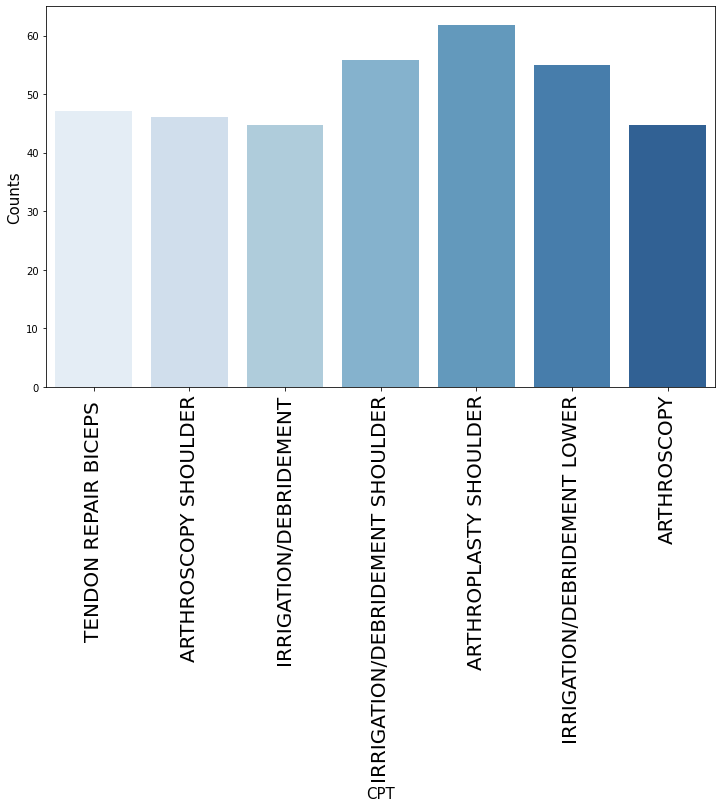

In [350]:
label_counts = df.mme.value_counts()
plt.figure(figsize = (12,7))
sns.barplot(df.index, df.mme, alpha = 0.9, palette="Blues")
plt.xticks(rotation = 'vertical',fontsize =20)
plt.xlabel('CPT', fontsize =15)
plt.ylabel('Counts', fontsize = 15)
plt.show()


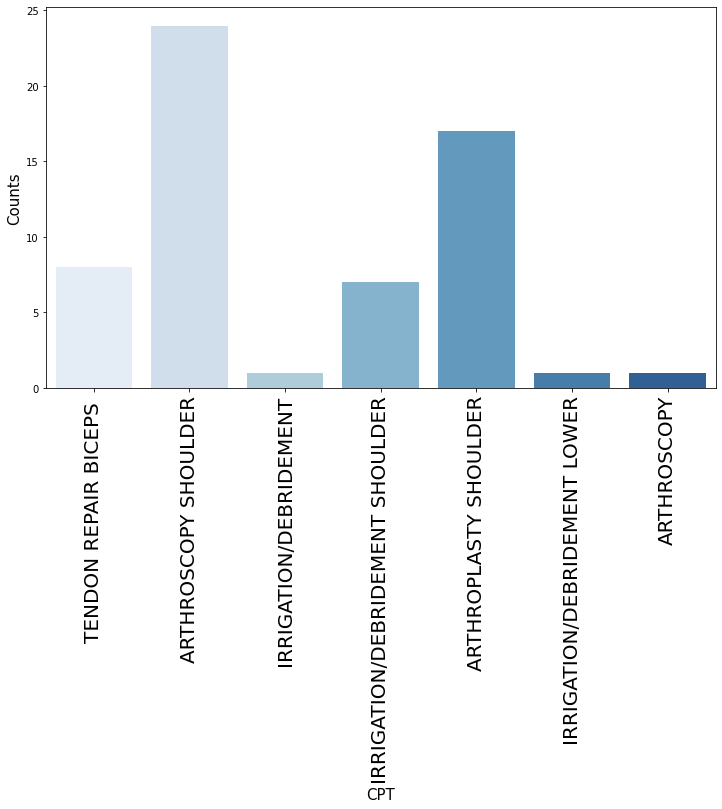

In [351]:
plt.figure(figsize = (12,7))
sns.barplot(df.index, df['count'], alpha = 0.9, palette="Blues")
plt.xticks(rotation = 'vertical',fontsize =20)
plt.xlabel('CPT', fontsize =15)
plt.ylabel('Counts', fontsize = 15)
plt.show()